In [1]:
import pandas as pd
import seaborn as sns
import xmltodict
import matplotlib.pyplot as plt

In [51]:
def loadTripData(root):

    data = pd.DataFrame(columns = ['Ruta', 'Tipo', 'Longitud', 'Salida', 'Llegada', 'Pérdida'])

    routes=[]
    vtypes=[]
    r_lengths=[]
    departs=[]
    arrivals=[]
    timeLosses=[]
    runs = []

    for i in range(31):
        xml_data = open(root+'results/trip.info_%d.xml'%i, 'r').read()
        xmlDict = xmltodict.parse(xml_data)  # Parse XML

        for trip in xmlDict['tripinfos']['tripinfo']:
            routes.append(trip['@id'].split('.')[0])
            vtypes.append(trip['@vType'])
            r_lengths.append(trip['@routeLength'])
            departs.append(trip['@depart'])
            arrivals.append(trip['@arrival'])
            timeLosses.append(trip['@timeLoss'])
            runs.append(i)

    data['Ruta']=routes
    data['Tipo']=vtypes
    data['Longitud']=r_lengths
    data['Salida']=departs
    data['Llegada']=arrivals
    data['Pérdida']=timeLosses
    data['NSim'] = runs
    data['Longitud']=data['Longitud'].astype(float)
    data['Salida']=data['Salida'].astype(float)
    data['Llegada']=data['Llegada'].astype(float)
    data['Pérdida']=data['Pérdida'].astype(float)
    
    return data

In [52]:
alldata = loadTripData('')
alldata['Esc'] = 'BAU'

for i in range(1,6):
    root = '../AutoNorte_E%d/'%i
    data = loadTripData(root)
    data['Esc'] = 'E%d'%i
    alldata = pd.concat([alldata,data])

In [58]:
alldata['Franja'] = pd.cut(alldata['Llegada'], [0,3600,7200,10800], labels = [1,2,3])

In [59]:
alldata

,Ruta,Tipo,Longitud,Salida,Llegada,Pérdida,NSim,Esc,Franja
0,Cl170_or_auto_sur_central,bog_driver,2230.74,10.0,182.0,12.10,0,BAU,1
1,Cl170_occ_auto_sur_central,bog_driver,2652.38,20.0,215.0,32.64,0,BAU,1
2,Cl170_occ_auto_sur_central,bog_driver,2652.38,14.0,218.0,29.10,0,BAU,1
3,Cl170_occ_auto_sur_lateral,bog_driver,2630.10,9.0,225.0,26.65,0,BAU,1
4,Cl170_or_auto_sur_central,bog_driver,2230.74,47.0,237.0,13.01,0,BAU,1
...,...,...,...,...,...,...,...,...,...
523604,chia_auto_sur_central,bog_driver,13006.31,4659.0,10796.0,5332.03,30,E5,3
523605,auto_norte_central_chia,bog_driver,13127.71,9976.0,10796.0,105.83,30,E5,3
523606,auto_norte_central_chia,bog_driver,13127.71,9531.0,10797.0,365.40,30,E5,3
523607,auto_norte_central_chia,bog_driver,13127.71,9530.0,10798.0,411.79,30,E5,3


In [60]:
rutas_importantes = ['auto_norte_central_chia','auto_norte_lateral_chia','ruta_auto_norte_central_Cl222', 'ruta_auto_norte_central_array',
       'ruta_auto_norte_lateral_array', 'chia_auto_sur_central', 'chia_auto_sur_lateral']

[Text(0, 0, 'auto_norte_central_chia'),
 Text(1, 0, 'auto_norte_lateral_chia'),
 Text(2, 0, 'chia_auto_sur_central'),
 Text(3, 0, 'chia_auto_sur_lateral'),
 Text(4, 0, 'ruta_auto_norte_central_Cl222'),
 Text(5, 0, 'ruta_auto_norte_central_array'),
 Text(6, 0, 'ruta_auto_norte_lateral_array')]

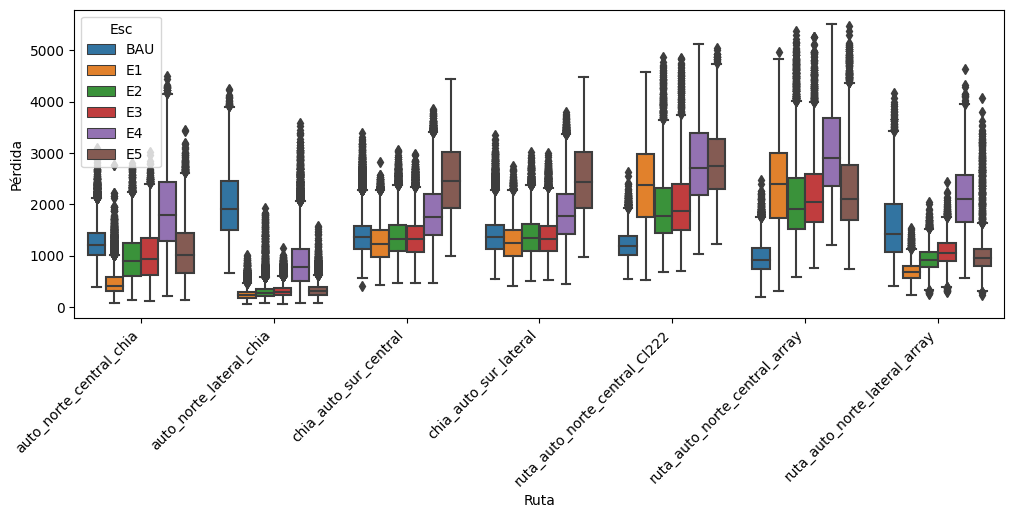

In [68]:
mask = (alldata['Ruta'].isin(rutas_importantes)) & (alldata['Franja']==2)

fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.boxplot(data = alldata[mask].sort_values(by=['Ruta','Esc']), x = 'Ruta', y='Pérdida', hue = 'Esc')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

/tmp/ipykernel_414/1234648047.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(-2000.0, 0, '−2000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '2000'),
 Text(4000.0, 0, '4000'),
 Text(6000.0, 0, '6000'),
 Text(8000.0, 0, '8000'),
 Text(10000.0, 0, '10000'),
 Text(12000.0, 0, '12000')]

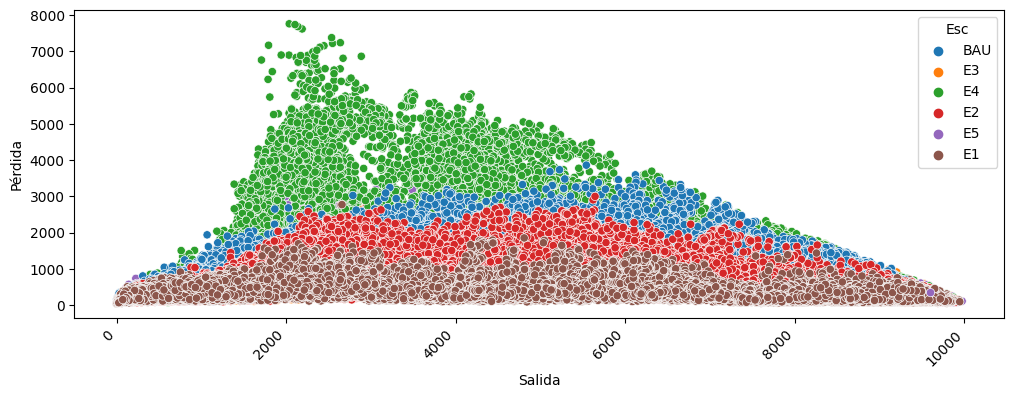

In [69]:
mask = (alldata['Ruta'].isin(rutas_importantes)) & (alldata['Ruta']==rutas_importantes[0])

fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.scatterplot(data = alldata[mask].sort_values(by='Ruta'), x = 'Salida', y='Pérdida', hue = 'Esc')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

<AxesSubplot: xlabel='Pérdida', ylabel='Count'>

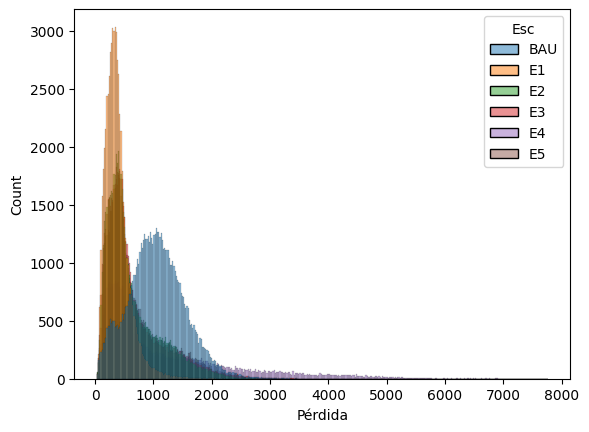

In [56]:
mask = (alldata['Ruta']==rutas_importantes[0])

sns.histplot(data = alldata[mask], x = 'Pérdida', hue = 'Esc')

In [35]:
alldata['conteo'] = alldata.groupby(['Esc','Ruta'])['Llegada'].cumcount()

<AxesSubplot: xlabel='Llegada', ylabel='conteo'>

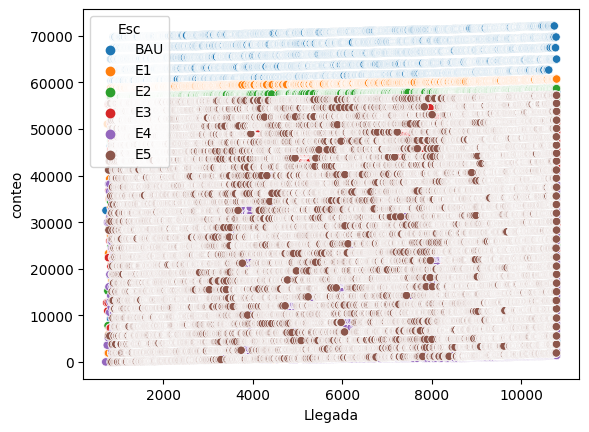

In [37]:
sns.scatterplot(data = alldata[mask], x = 'Llegada', y= 'conteo', hue = 'Esc')

In [45]:
mask = (alldata['Ruta']==rutas_importantes[0]) & (alldata['Esc']=='E2')
alldata[mask]

,Ruta,Tipo,Longitud,Salida,Llegada,Pérdida,Esc,Sección,Franja,conteo
284,auto_norte_central_chia,bog_driver,13128.25,46.0,853.0,78.28,E2,1,1,0
312,auto_norte_central_chia,bog_driver,13128.25,8.0,879.0,41.51,E2,1,1,1
332,auto_norte_central_chia,bog_driver,13128.25,20.0,899.0,70.15,E2,1,1,2
369,auto_norte_central_chia,bog_driver,13128.25,7.0,933.0,48.91,E2,1,1,3
370,auto_norte_central_chia,bog_driver,13128.25,25.0,933.0,44.62,E2,1,1,4
...,...,...,...,...,...,...,...,...,...,...
622890,auto_norte_central_chia,bog_driver,13128.25,9432.0,10778.0,551.78,E2,3,3,58665
622893,auto_norte_central_chia,bog_driver,13128.25,9537.0,10780.0,343.75,E2,3,3,58666
622894,auto_norte_central_chia,bog_driver,13128.25,9785.0,10781.0,216.58,E2,3,3,58667
622909,auto_norte_central_chia,bog_driver,13128.25,9591.0,10795.0,211.90,E2,3,3,58668


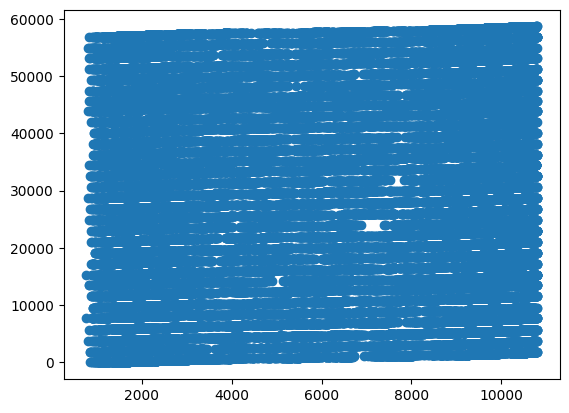

In [50]:
plt.plot(alldata[mask]['Llegada'], alldata[mask]['conteo'], 'o')

In [49]:
alldata[mask]['conteo']

284           0
312           1
332           2
369           3
370           4
          ...  
622890    58665
622893    58666
622894    58667
622909    58668
622910    58669
Name: conteo, Length: 58670, dtype: int64